In [69]:
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path

from astropy.nddata import CCDData
from astropy.stats import mad_std
from astropy.visualization import simple_norm
from astropy import units as u
import ccdproc as ccdp
from ccdproc import subtract_bias

In [33]:
DEBUG = True

if not DEBUG:
    import warnings
    import logging
    from astropy.wcs import FITSFixedWarning
    from astropy.io.fits.verify import VerifyWarning
    from astropy import logger

    warnings.simplefilter('ignore', FITSFixedWarning)
    warnings.simplefilter('ignore', VerifyWarning)
    logging.getLogger('astropy').setLevel(logging.ERROR)
else:
    import warnings
    import logging
    from astropy.wcs import FITSFixedWarning
    from astropy.io.fits.verify import VerifyWarning
    from astropy import logger
    
    warnings.simplefilter('default', FITSFixedWarning)
    warnings.simplefilter('default', VerifyWarning)
    logging.getLogger('astropy').setLevel(logging.INFO)

In [34]:
files = ccdp.ImageFileCollection('../data_NGC6888/lights')
files.summary['file', 'imagetyp', 'exptime', 'naxis1', 'naxis2', 'gain', 'egain']

file,imagetyp,exptime,naxis1,naxis2,gain,egain
str30,str11,float64,int64,int64,int64,float64
L_M82_0176_Bin1x1_180s_22C.fit,Light Frame,180.0,3840,2160,252,0.620981216430664
L_M82_0177_Bin1x1_180s_22C.fit,Light Frame,180.0,3840,2160,252,0.620981216430664
L_M82_0178_Bin1x1_180s_23C.fit,Light Frame,180.0,3840,2160,252,0.620981216430664
L_M82_0179_Bin1x1_180s_23C.fit,Light Frame,180.0,3840,2160,252,0.620981216430664
L_M82_0180_Bin1x1_180s_23C.fit,Light Frame,180.0,3840,2160,252,0.620981216430664
L_M82_0181_Bin1x1_180s_23C.fit,Light Frame,180.0,3840,2160,252,0.620981216430664
L_M82_0182_Bin1x1_180s_23C.fit,Light Frame,180.0,3840,2160,252,0.620981216430664
L_M82_0183_Bin1x1_180s_23C.fit,Light Frame,180.0,3840,2160,252,0.620981216430664
L_M82_0184_Bin1x1_180s_23C.fit,Light Frame,180.0,3840,2160,252,0.620981216430664


In [35]:
#копируем файлы из папки data_NGC6888 в папку reduced
parent_dir = Path('..')
calibrated_data = parent_dir / 'reduced'
calibrated_data.mkdir(exist_ok=True)

lights = files.files_filtered(imagetyp='Light Frame', include_path=True)

import shutil

for light in lights:
    shutil.copy(light, calibrated_data)

In [59]:
calibrated_path = Path('../reduced')
reduced_images = ccdp.ImageFileCollection(calibrated_path)

calibrated_lights = reduced_images.files_filtered(imagetyp='Light Frame', include_path=True)

light_file = calibrated_lights[0]
light_ccd = CCDData.read(light_file, unit='adu') 

light_data = light_ccd.data

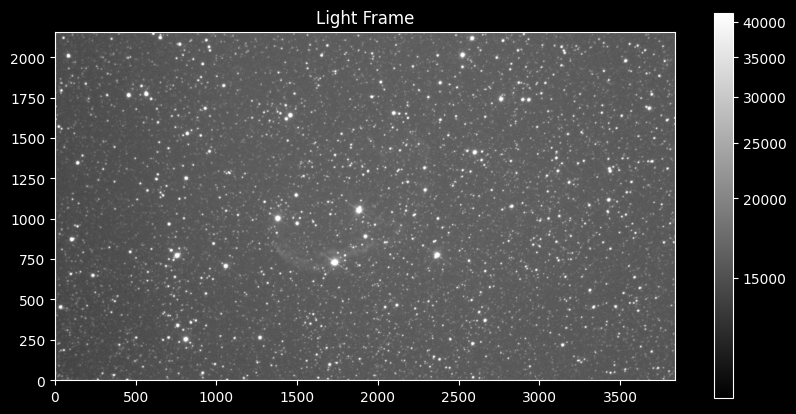

In [37]:
norm = simple_norm(light_data, stretch='sqrt', percent=99)
plt.style.use("dark_background")
plt.figure(figsize=(10, 5))
plt.imshow(light_data, cmap='gray', norm=norm, origin='lower')
plt.colorbar()
plt.title('Light Frame')
plt.show()

Mean: 16810.639880401235
STD: 4097.757138736811
MAD STD: 3036.369343499473


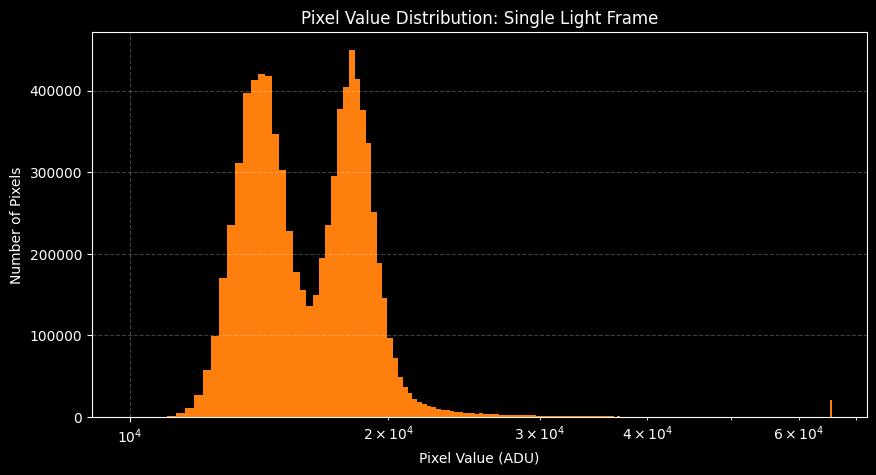

In [38]:
light_hist = light_data.flatten()

print(f'Mean: {np.mean(light_data)}')
print(f'STD: {np.std(light_data)}')
print(f'MAD STD: {mad_std(light_data)}')

plt.figure(figsize=(10, 5))
plt.hist(light_hist, bins=200, color='tab:orange')
plt.title('Pixel Value Distribution: Single Light Frame')
plt.xlabel('Pixel Value (ADU)')
plt.ylabel('Number of Pixels')
plt.grid(linestyle='dashed', alpha=0.25)
plt.semilogx()
plt.show()

In [68]:
combined_bias = [ccd for ccd in reduced_images.ccds(imagetyp='Bias Frame', combined=True)][0]

combined_dark = CCDData.read(calibrated_data / 'combined_dark_avg_wo_bias.fit')

In [70]:
all_reds = []
light_ccds = []
for light, file_name in reduced_images.ccds(imagetyp='Light Frame',
                                            ccd_kwargs={'unit': 'adu'},
                                            return_fname=True):
    light_ccds.append(light)

    reduced = light
    
    reduced = subtract_bias(reduced, combined_bias)

    reduced = ccdp.subtract_dark(reduced, combined_dark, 
                                 exposure_time='exptime', exposure_unit=u.second)
    
    all_reds.append(reduced)
    reduced.write(calibrated_data / file_name, overwrite=True)

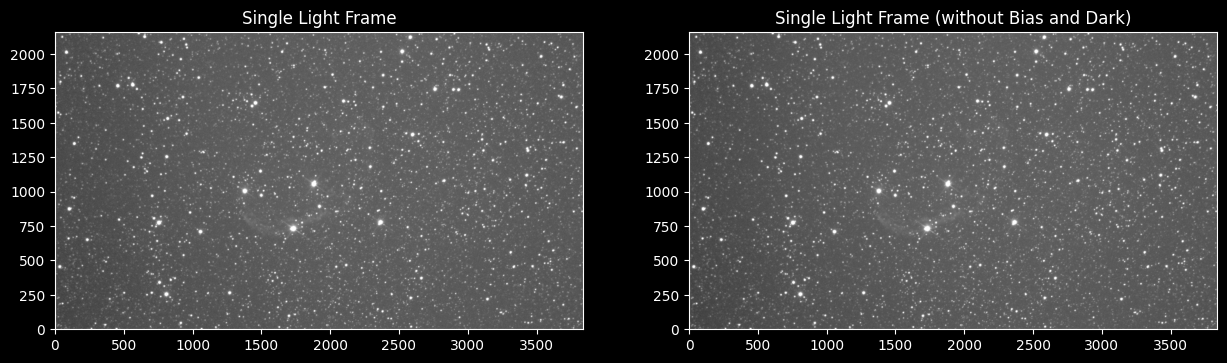

In [74]:
fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(15,10))

norm = simple_norm(light_data, stretch='sqrt', percent=99)
im1 = ax1.imshow(light_data, cmap='gray', norm=norm, origin='lower')
ax1.set_title('Single Light Frame')

norm = simple_norm(all_reds[0].data, stretch='sqrt', percent=99)
im3 = ax2.imshow(all_reds[0].data, cmap='gray', norm=norm, origin='lower')
ax2.set_title('Single Light Frame (without Bias and Dark)')

plt.show()

In [75]:
combined_light = ccdp.combine(all_reds,
                             method='average',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std,
                             mem_limit=350e6,
                             unit='adu'
                            )

combined_light.meta['combined'] = True
combined_light.write(calibrated_data / 'combined_light.fit', overwrite=True)

INFO:astropy:splitting each image into 64 chunks to limit memory usage to 350000000.0 bytes.


INFO: splitting each image into 64 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


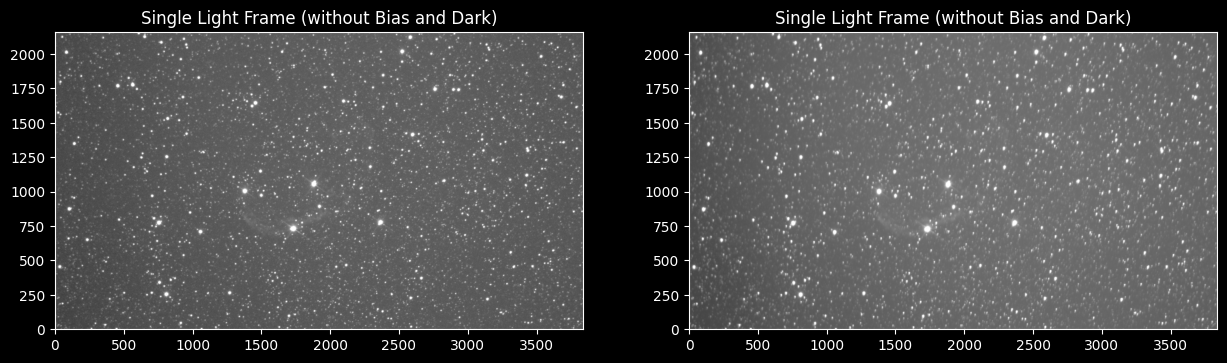

In [77]:
fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(15,10))

norm = simple_norm(all_reds[0].data, stretch='sqrt', percent=99)
im1 = ax1.imshow(all_reds[0].data, cmap='gray', norm=norm, origin='lower')
ax1.set_title('Single Light Frame (without Bias and Dark)')

norm = simple_norm(combined_light.data, stretch='sqrt', percent=99)
im2 = ax2.imshow(combined_light.data, cmap='gray', norm=norm, origin='lower')
ax2.set_title('Single Light Frame (without Bias and Dark)')


plt.show()

(array([1.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        2.000000e+01, 1.000000e+00, 1.000000e+00, 2.000000e+00,
        0.000000e+00, 0.000000e+00, 1.000000e+00, 0.000000e+00,
        4.000000e+00, 5.000000e+00, 6.000000e+00, 6.000000e+00,
        9.000000e+00, 1.200000e+01, 2.000000e+01, 4.200000e+01,
        9.600000e+01, 9.468100e+04, 5.553860e+05, 1.388947e+06,
        8.743030e+05, 8.491190e+05, 1.779860e+05, 3.508730e+05,
        8.163660e+05, 2.002089e+06, 7.435660e+05, 1.576960e+05,
        6.999000e+04, 4.154800e+04, 2.779900e+04, 2.043700e+04,
        1.522200e+04, 1.230200e+04, 9.79

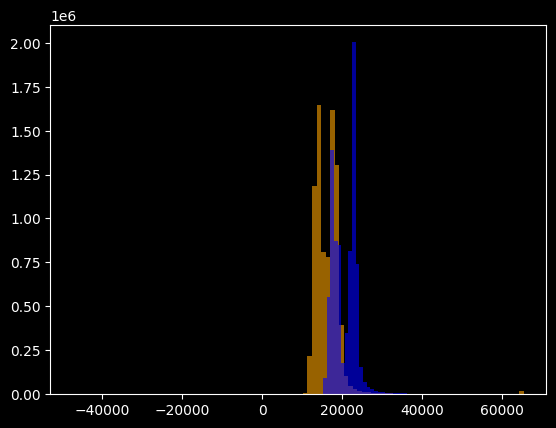

In [80]:
plt.hist(all_reds[0].data.flatten(), bins=100, color='orange', alpha=0.6)
plt.hist(combined_light.data.flatten(), bins=100, color='blue', alpha=0.6)